# COMPASS Integration Roadmap - Solar PV Ordinances Analysis

<details>
<summary><b>Click to toggle code visibility</b></summary>

*Note: This toggle works in HTML exports. Code cells can be hidden/shown.*

</details>

In [ ]:
#import statements

import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from rich import print

In [18]:
#Reading in ordinace data
ord = pd.read_excel('/Users/gzuckerm/Desktop/eagle_transfers/from_eagle/Supply_Curves/FY26/COMPASS/Solar Ordinances 2025.xlsx', skiprows=1)
old_ord = pd.read_excel('/Users/gzuckerm/Desktop/eagle_transfers/from_eagle/Supply_Curves/FY26/COMPASS/Solar Ordinances.xlsx', sheet_name='County, State')

/Users/gzuckerm/anaconda3/envs/local/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


In [4]:
#Examining the numerical ordiances
numeric_count = pd.to_numeric(ord.Value, errors='coerce').notna().sum()
print(f"[bold]Number of rows with numeric Value: {numeric_count} out of {len(ord)} total rows.[/bold]")

Number of rows with numeric Value: 4375 out of 11458 total rows.

In [9]:
#Looking at the type of ordinanaces with numeric values

#new 
ord['is_numeric'] = pd.to_numeric(ord['Value'], errors='coerce').notna()

usable_ord = ord[ord['is_numeric']]
usable_ord.Feature.unique()

array(['Roads', 'Property Line (Non-Participating)', 'Maximum Height',
       'Structures (Non-Participating)', 'Minimum Lot Size', 'Water',
       'Public Conservation Lands', 'Noise', 'Maximum Lot Size',
       'Maximum Project Size', 'Railroads', 'Transmission', 'Coverage',
       'Panel Spacing', 'Other Secs', 'Property Line (Participating)',
       'Structures (Participating)'], dtype=object)

In [20]:
# Report the number of ordinances for each Feature type in usable_ord
feature_counts = usable_ord['Feature'].value_counts()
output = "Number of ordinances for each type (Feature) in the new data set:\n"
for feature, count in feature_counts.items():
    output += f"{feature}: {count}\n"
print(output)

feature_counts = old_ord['Feature Type'].value_counts()
output = "Number of ordinances for each type (Feature) in the old data set:\n"
for feature, count in feature_counts.items():
    output += f"{feature}: {count}\n"
print(output)

Number of ordinances for each type (Feature) in the new data set:
Property Line (Non-Participating): 954
Maximum Height: 808
Structures (Non-Participating): 608
Roads: 527
Minimum Lot Size: 457
Noise: 330
Coverage: 200
Maximum Lot Size: 138
Water: 124
Public Conservation Lands: 61
Maximum Project Size: 47
Other Secs: 36
Transmission: 27
Railroads: 21
Structures (Participating): 18
Property Line (Participating): 17
Panel Spacing: 2

Number of ordinances for each type (Feature) in the old data set:
Property Line: 230
Structures: 137
Roads: 117
Height: 115
Height : 75
Minimum Lot Size: 39
Sound: 33
Highway: 20
Maximum Lot Size: 10
Waters: 7
Minimum Lot Size : 7
Total Installation: 4
Maximum Lot Coverage: 4
Density: 4
Coverage: 4
Total Installation Size: 2
Maximum Project Size: 2
maximum lot size: 2
Rivers: 2
Banned: 2
Density : 1
Maximum Lot Size : 1
Lakes: 1
Maximum lot size: 1
Property Line : 1
Property Lines: 1
M.D. Route 413: 1
Minimum lot size: 1
Wetlands: 1
Moratorium : 1
Property line: 1
Sounds: 1
U.S. Route 13: 1
Mimimum Lot Size: 1
Minimum lot Size: 1
Noise: 1
Railroads: 1
MInimum Lot Size: 1
Road: 1
Noise : 1
Moratorium: 1
Lankford Highway: 1

### Exisiting Capabilities

We have the capability to model setback ordiances for **structures** (see note below on particpating vs non-participating), **roads**, **transmission**, **railroads**, **property lines**, and **water**. We can update to include setbacks from **other SECS** and **public conservation lands** (though we will need to define this).

Though we have the capability to model **property line** setbacks, it is not a a low hanging fruit. Some questions remain including whether our parcel dataset is an appropriate represenation (multiple parcels with same owner), how to account for participating vs. non-participating, and the computation limits associated with calculating setbacks for that many features.

**Maximum height** ordinances, while very common, will not signigicantly impact technical potential due to non-restrictive heights, and thus won't be considered. Similarly, **noise** ordinances, while common, will not be restrictive, and thus will not be considered.

Note:
In the .gpkg, "structures" represents non-participating values while, participating is specifically called out. Because we do not know which structures are participating, we cannot use it.

#### Roads

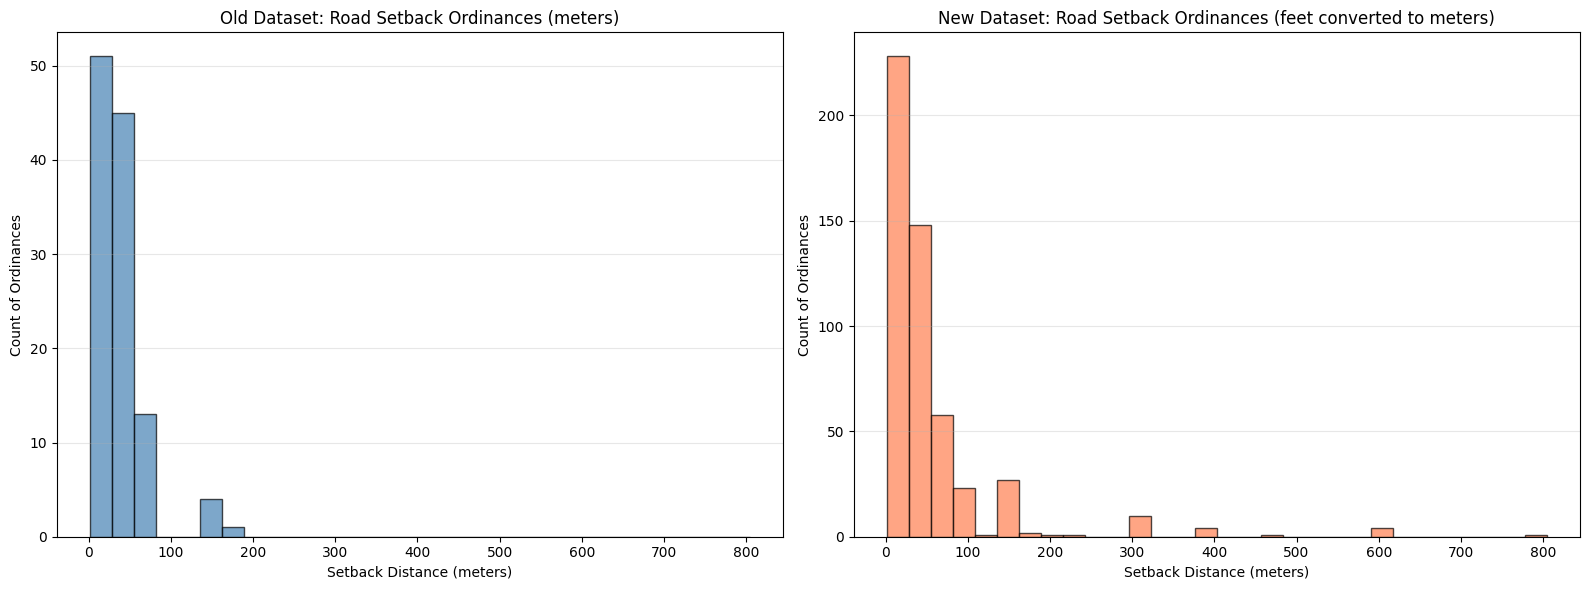

Old Dataset (Roads, Meters only - 97.4% of all road ordinances):
  Count: 114
  Mean: 34.75 m
  Median: 30.48 m
  Min: 3.00 m
  Max: 182.88 m

New Dataset (Roads, Feet only converted to Meters - 96.6% of all road ordinances):
  Count: 509
  Mean: 54.27 m
  Median: 30.48 m
  Min: 1.52 m
  Max: 804.67 m

In [31]:

# Create side-by-side histograms comparing old and new road ordinance values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Old ordinances - Roads with units of Meters
old_road_data = old_ord[old_ord['Feature Type'] == 'Roads']
old_road_data = old_road_data[old_road_data['Value Type'] == 'Meters']
old_road_values = pd.to_numeric(old_road_data['Value'], errors='coerce').dropna()

# New ordinances - Roads with units of feet (convert to meters)
new_road_data = usable_ord[usable_ord['Feature'] == 'Roads']
new_road_data = new_road_data[new_road_data['Units'] == 'feet']
new_road_values = pd.to_numeric(new_road_data['Value'], errors='coerce').dropna()
new_road_values_meters = new_road_values * 0.3048  # Convert feet to meters

# Determine common bin edges for aligned x-axes
all_values = pd.concat([old_road_values, new_road_values_meters])
bins = np.histogram_bin_edges(all_values, bins=30)

# Plot old ordinances
ax1.hist(old_road_values, bins=bins, edgecolor='black', alpha=0.7, color='steelblue')
ax1.set_xlabel('Setback Distance (meters)')
ax1.set_ylabel('Count of Ordinances')
ax1.set_title('Old Dataset: Road Setback Ordinances (meters)')
ax1.grid(True, alpha=0.3, axis='y')

# Plot new ordinances (converted to meters)
ax2.hist(new_road_values_meters, bins=bins, edgecolor='black', alpha=0.7, color='coral')
ax2.set_xlabel('Setback Distance (meters)')
ax2.set_ylabel('Count of Ordinances')
ax2.set_title('New Dataset: Road Setback Ordinances (feet converted to meters)')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Calculate percentages for old dataset
old_roads_total = len(old_ord[old_ord['Feature Type'] == 'Roads'])
old_meters_count = len(old_road_values)
old_meters_pct = (old_meters_count / old_roads_total * 100) if old_roads_total > 0 else 0

# Calculate percentages for new dataset
new_roads_total = len(usable_ord[usable_ord['Feature'] == 'Roads'])
new_feet_count = len(new_road_values_meters)
new_feet_pct = (new_feet_count / new_roads_total * 100) if new_roads_total > 0 else 0

# Print summary statistics
stats_output = []
stats_output.append(f"Old Dataset (Roads, Meters only - {old_meters_pct:.1f}% of all road ordinances):")
stats_output.append(f"  Count: {len(old_road_values)}")
if len(old_road_values) > 0:
    stats_output.append(f"  Mean: {old_road_values.mean():.2f} m")
    stats_output.append(f"  Median: {old_road_values.median():.2f} m")
    stats_output.append(f"  Min: {old_road_values.min():.2f} m")
    stats_output.append(f"  Max: {old_road_values.max():.2f} m")

stats_output.append(f"\nNew Dataset (Roads, Feet only converted to Meters - {new_feet_pct:.1f}% of all road ordinances):")
stats_output.append(f"  Count: {len(new_road_values_meters)}")
if len(new_road_values_meters) > 0:
    stats_output.append(f"  Mean: {new_road_values_meters.mean():.2f} m")
    stats_output.append(f"  Median: {new_road_values_meters.median():.2f} m")
    stats_output.append(f"  Min: {new_road_values_meters.min():.2f} m")
    stats_output.append(f"  Max: {new_road_values_meters.max():.2f} m")

print("\n".join(stats_output))

#### Transmission

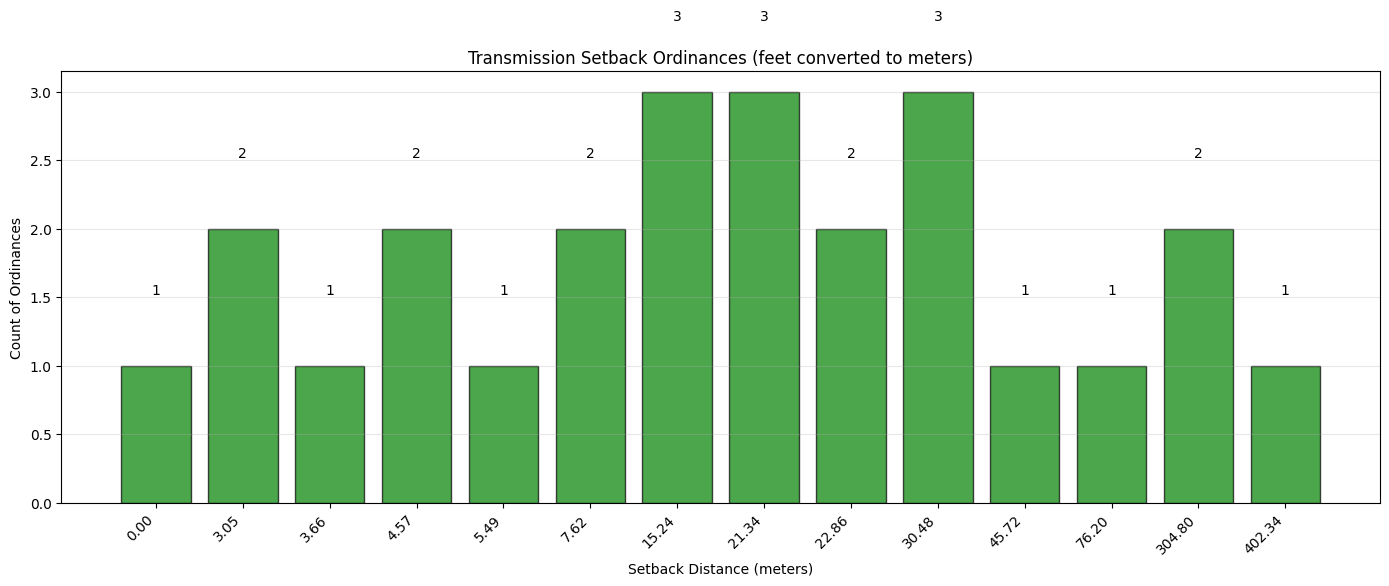

Transmission ordinances (feet - 92.6% of all transmission ordinances):
  Count: 25
  Mean: 56.81 m
  Median: 21.34 m
  Min: 0.00 m
  Max: 402.34 m
  Standard deviation: 108.20 m
  10th percentile: 3.29 m
  25th percentile: 5.49 m
  50th percentile: 21.34 m
  75th percentile: 30.48 m
  90th percentile: 213.36 m

In [ ]:
# Create histogram for Transmission ordinances similar to Roads analysis
# no old transmission
# First, let's examine the transmission data
transmission_data = usable_ord[usable_ord['Feature'] == 'Transmission']

# Collect statistics for printing later
transmission_stats = []

if len(transmission_data) > 0:
    # Check the most common unit
    unit_counts = transmission_data['Units'].value_counts()
    most_common_unit = unit_counts.index[0]
    
    # Filter for most common unit
    transmission_filtered = transmission_data[transmission_data['Units'] == most_common_unit]
    transmission_values = pd.to_numeric(transmission_filtered['Value'], errors='coerce').dropna()
    
    # Convert to meters if in feet
    if most_common_unit == 'feet':
        transmission_values_meters = transmission_values * 0.3048
        unit_label = 'feet converted to meters'
    else:
        transmission_values_meters = transmission_values
        unit_label = most_common_unit
    
    # Create bar plot with value counts
    value_counts = transmission_values_meters.value_counts().sort_index()
    
    plt.figure(figsize=(14, 6))
    x_positions = range(len(value_counts))
    bars = plt.bar(x_positions, value_counts.values, edgecolor='black', alpha=0.7, color='green')
    plt.xlabel(f'Setback Distance (meters)')
    plt.ylabel('Count of Ordinances')
    plt.title(f'Transmission Setback Ordinances ({unit_label})')
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on top of bars
    for i, count in enumerate(value_counts.values):
        plt.text(i, count + 0.5, str(count), ha='center', va='bottom')
    
    # Set x-axis labels
    plt.xticks(x_positions, [f'{v:.2f}' for v in value_counts.index], rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate percentages
    transmission_total = len(transmission_data)
    filtered_count = len(transmission_values_meters)
    filtered_pct = (filtered_count / transmission_total * 100) if transmission_total > 0 else 0
    
    # Collect summary statistics
    transmission_stats.append(f"Transmission ordinances ({most_common_unit} - {filtered_pct:.1f}% of all transmission ordinances):")
    transmission_stats.append(f"  Count: {len(transmission_values_meters)}")
    if len(transmission_values_meters) > 0:
        transmission_stats.append(f"  Mean: {transmission_values_meters.mean():.2f} m")
        transmission_stats.append(f"  Median: {transmission_values_meters.median():.2f} m")
        transmission_stats.append(f"  Min: {transmission_values_meters.min():.2f} m")
        transmission_stats.append(f"  Max: {transmission_values_meters.max():.2f} m")
        transmission_stats.append(f"  Standard deviation: {transmission_values_meters.std():.2f} m")
        transmission_stats.append(f"  10th percentile: {transmission_values_meters.quantile(0.10):.2f} m")
        transmission_stats.append(f"  25th percentile: {transmission_values_meters.quantile(0.25):.2f} m")
        transmission_stats.append(f"  50th percentile: {transmission_values_meters.quantile(0.50):.2f} m")
        transmission_stats.append(f"  75th percentile: {transmission_values_meters.quantile(0.75):.2f} m")
        transmission_stats.append(f"  90th percentile: {transmission_values_meters.quantile(0.90):.2f} m")
else:
    transmission_stats.append("No Transmission ordinances found in the data.")

# Print all statistics
if transmission_stats:
    print("\n".join(transmission_stats))

#### Railroads

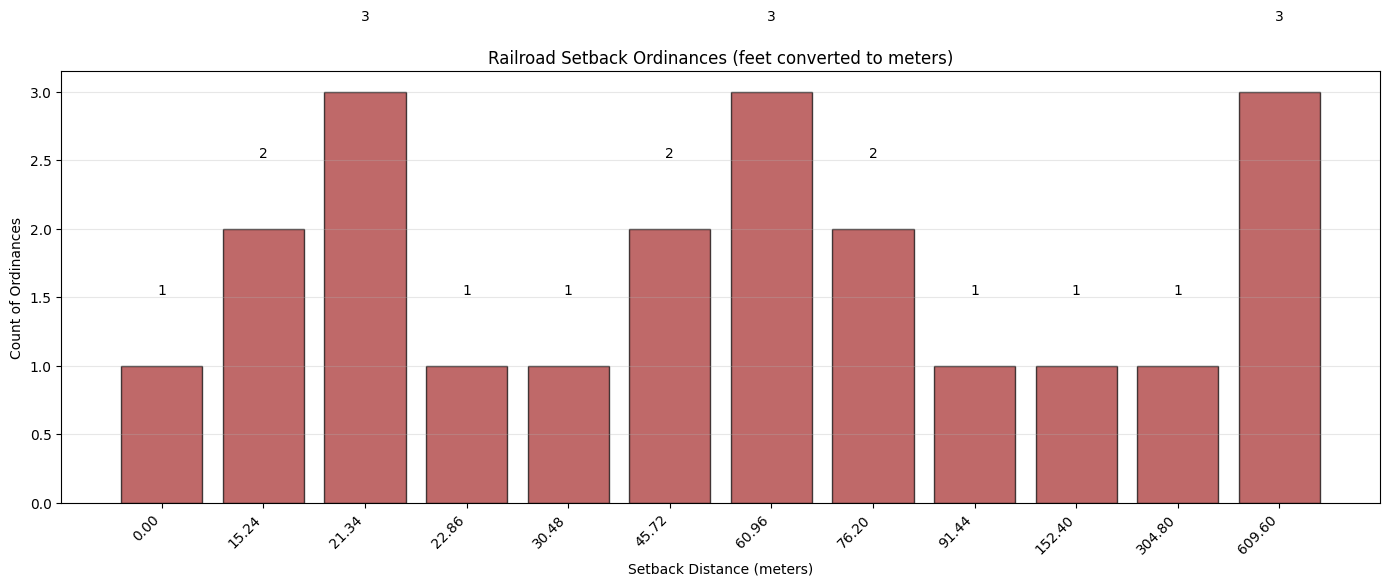

Railroad ordinances (feet - 100.0% of all railroad ordinances):
  Count: 21
  Mean: 140.57 m
  Median: 60.96 m
  Min: 0.00 m
  Max: 609.60 m
  Standard deviation: 206.71 m
  10th percentile: 15.24 m
  25th percentile: 21.34 m
  50th percentile: 60.96 m
  75th percentile: 91.44 m
  90th percentile: 609.60 m

In [38]:
# Create histogram for Railroad ordinances similar to Transmission analysis
railroad_data = usable_ord[usable_ord['Feature'] == 'Railroads']

# Collect statistics for printing later
railroad_stats = []

if len(railroad_data) > 0:
    # Check the most common unit
    unit_counts = railroad_data['Units'].value_counts()
    most_common_unit = unit_counts.index[0]
    
    # Filter for most common unit
    railroad_filtered = railroad_data[railroad_data['Units'] == most_common_unit]
    railroad_values = pd.to_numeric(railroad_filtered['Value'], errors='coerce').dropna()
    
    # Convert to meters if in feet
    if most_common_unit == 'feet':
        railroad_values_meters = railroad_values * 0.3048
        unit_label = 'feet converted to meters'
    else:
        railroad_values_meters = railroad_values
        unit_label = most_common_unit
    
    # Create bar plot with value counts
    value_counts = railroad_values_meters.value_counts().sort_index()
    
    plt.figure(figsize=(14, 6))
    x_positions = range(len(value_counts))
    bars = plt.bar(x_positions, value_counts.values, edgecolor='black', alpha=0.7, color='brown')
    plt.xlabel(f'Setback Distance (meters)')
    plt.ylabel('Count of Ordinances')
    plt.title(f'Railroad Setback Ordinances ({unit_label})')
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on top of bars
    for i, count in enumerate(value_counts.values):
        plt.text(i, count + 0.5, str(count), ha='center', va='bottom')
    
    # Set x-axis labels
    plt.xticks(x_positions, [f'{v:.2f}' for v in value_counts.index], rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate percentages
    railroad_total = len(railroad_data)
    filtered_count = len(railroad_values_meters)
    filtered_pct = (filtered_count / railroad_total * 100) if railroad_total > 0 else 0
    
    # Collect summary statistics
    railroad_stats.append(f"Railroad ordinances ({most_common_unit} - {filtered_pct:.1f}% of all railroad ordinances):")
    railroad_stats.append(f"  Count: {len(railroad_values_meters)}")
    if len(railroad_values_meters) > 0:
        railroad_stats.append(f"  Mean: {railroad_values_meters.mean():.2f} m")
        railroad_stats.append(f"  Median: {railroad_values_meters.median():.2f} m")
        railroad_stats.append(f"  Min: {railroad_values_meters.min():.2f} m")
        railroad_stats.append(f"  Max: {railroad_values_meters.max():.2f} m")
        railroad_stats.append(f"  Standard deviation: {railroad_values_meters.std():.2f} m")
        railroad_stats.append(f"  10th percentile: {railroad_values_meters.quantile(0.10):.2f} m")
        railroad_stats.append(f"  25th percentile: {railroad_values_meters.quantile(0.25):.2f} m")
        railroad_stats.append(f"  50th percentile: {railroad_values_meters.quantile(0.50):.2f} m")
        railroad_stats.append(f"  75th percentile: {railroad_values_meters.quantile(0.75):.2f} m")
        railroad_stats.append(f"  90th percentile: {railroad_values_meters.quantile(0.90):.2f} m")
else:
    railroad_stats.append("No Railroad ordinances found in the data.")

# Print all statistics
if railroad_stats:
    print("\n".join(railroad_stats))

#### Water

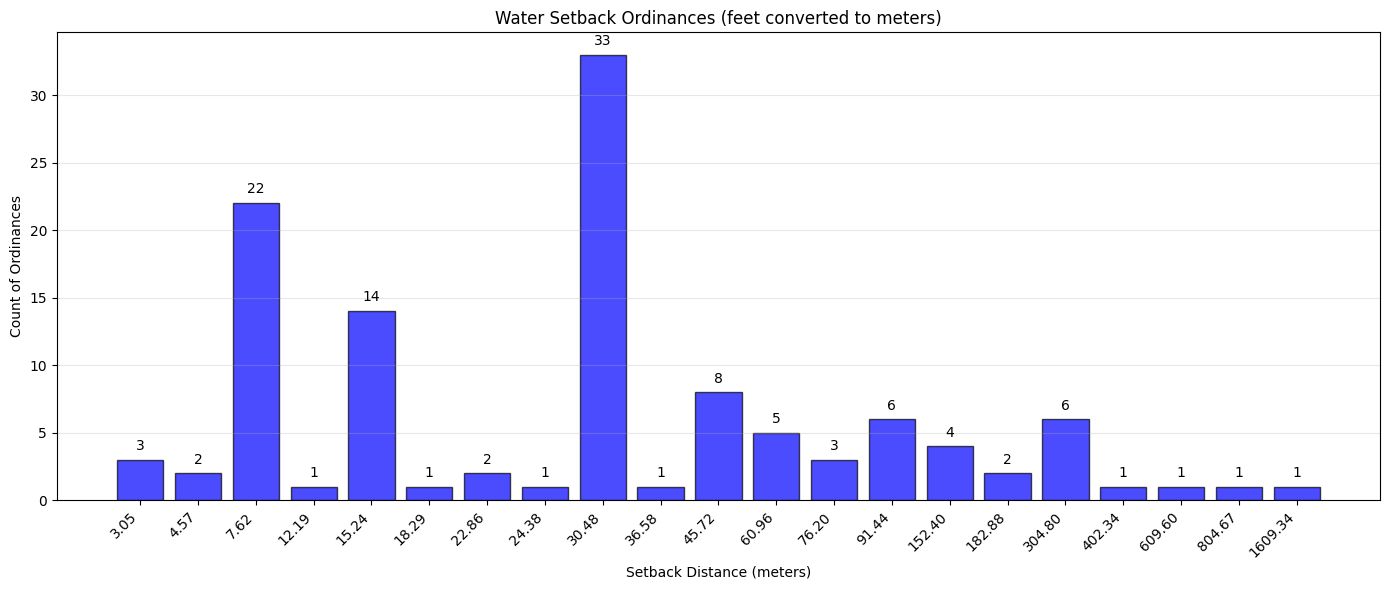

Water ordinances (feet - 95.2% of all water ordinances):
  Count: 118
  Mean: 78.14 m
  Median: 30.48 m
  Min: 3.05 m
  Max: 1609.34 m
  Standard deviation: 182.79 m
  10th percentile: 7.62 m
  25th percentile: 15.24 m
  50th percentile: 30.48 m
  75th percentile: 57.15 m
  90th percentile: 161.54 m

In [40]:
# Create histogram for Water ordinances similar to Transmission analysis
water_data = usable_ord[usable_ord['Feature'] == 'Water']

# Collect statistics for printing later
water_stats = []

if len(water_data) > 0:
    # Check the most common unit
    unit_counts = water_data['Units'].value_counts()
    most_common_unit = unit_counts.index[0]
    
    # Filter for most common unit
    water_filtered = water_data[water_data['Units'] == most_common_unit]
    water_values = pd.to_numeric(water_filtered['Value'], errors='coerce').dropna()
    
    # Convert to meters if in feet
    if most_common_unit == 'feet':
        water_values_meters = water_values * 0.3048
        unit_label = 'feet converted to meters'
    else:
        water_values_meters = water_values
        unit_label = most_common_unit
    
    # Create bar plot with value counts
    value_counts = water_values_meters.value_counts().sort_index()
    
    plt.figure(figsize=(14, 6))
    x_positions = range(len(value_counts))
    bars = plt.bar(x_positions, value_counts.values, edgecolor='black', alpha=0.7, color='blue')
    plt.xlabel(f'Setback Distance (meters)')
    plt.ylabel('Count of Ordinances')
    plt.title(f'Water Setback Ordinances ({unit_label})')
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on top of bars
    for i, count in enumerate(value_counts.values):
        plt.text(i, count + 0.5, str(count), ha='center', va='bottom')
    
    # Set x-axis labels
    plt.xticks(x_positions, [f'{v:.2f}' for v in value_counts.index], rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate percentages
    water_total = len(water_data)
    filtered_count = len(water_values_meters)
    filtered_pct = (filtered_count / water_total * 100) if water_total > 0 else 0
    
    # Collect summary statistics
    water_stats.append(f"Water ordinances ({most_common_unit} - {filtered_pct:.1f}% of all water ordinances):")
    water_stats.append(f"  Count: {len(water_values_meters)}")
    if len(water_values_meters) > 0:
        water_stats.append(f"  Mean: {water_values_meters.mean():.2f} m")
        water_stats.append(f"  Median: {water_values_meters.median():.2f} m")
        water_stats.append(f"  Min: {water_values_meters.min():.2f} m")
        water_stats.append(f"  Max: {water_values_meters.max():.2f} m")
        water_stats.append(f"  Standard deviation: {water_values_meters.std():.2f} m")
        water_stats.append(f"  10th percentile: {water_values_meters.quantile(0.10):.2f} m")
        water_stats.append(f"  25th percentile: {water_values_meters.quantile(0.25):.2f} m")
        water_stats.append(f"  50th percentile: {water_values_meters.quantile(0.50):.2f} m")
        water_stats.append(f"  75th percentile: {water_values_meters.quantile(0.75):.2f} m")
        water_stats.append(f"  90th percentile: {water_values_meters.quantile(0.90):.2f} m")
else:
    water_stats.append("No Water ordinances found in the data.")

# Print all statistics
if water_stats:
    print("\n".join(water_stats))

#### Structures

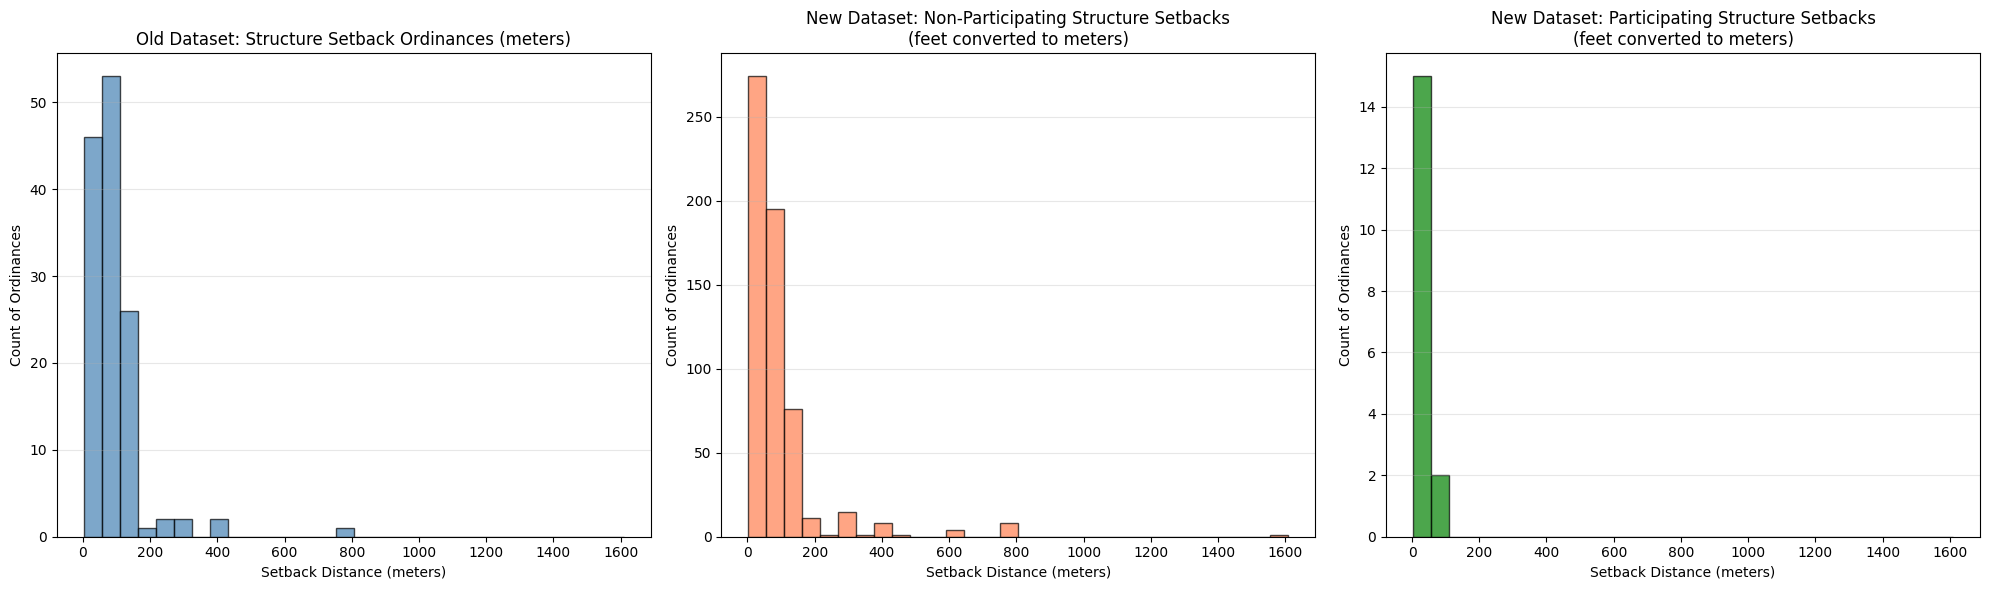

Old Dataset (Structures, Meters only - 97.1% of all structure ordinances):
  Count: 133
  Mean: 91.53 m
  Median: 60.96 m
  Min: 15.24 m
  Max: 804.00 m

New Dataset (Non-Participating Structures, Feet only converted to Meters - 97.9% of all non-participating structure
ordinances):
  Count: 595
  Mean: 94.40 m
  Median: 60.96 m
  Min: 3.05 m
  Max: 1609.34 m

New Dataset (Participating Structures, Feet only converted to Meters - 94.4% of all participating structure 
ordinances):
  Count: 17
  Mean: 29.67 m
  Median: 22.86 m
  Min: 3.05 m
  Max: 91.44 m

In [33]:
# Create side-by-side histograms comparing old and new structure ordinance values
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Old ordinances - Structures with units of Meters
old_structure_data = old_ord[old_ord['Feature Type'] == 'Structures']
old_structure_data = old_structure_data[old_structure_data['Value Type'] == 'Meters']
old_structure_values = pd.to_numeric(old_structure_data['Value'], errors='coerce').dropna()

# New ordinances - Structures (Non-Participating) with units of feet (convert to meters)
new_structure_nonpart_data = usable_ord[usable_ord['Feature'] == 'Structures (Non-Participating)']
new_structure_nonpart_data = new_structure_nonpart_data[new_structure_nonpart_data['Units'] == 'feet']
new_structure_nonpart_values = pd.to_numeric(new_structure_nonpart_data['Value'], errors='coerce').dropna()
new_structure_nonpart_values_meters = new_structure_nonpart_values * 0.3048  # Convert feet to meters

# New ordinances - Structures (Participating) with units of feet (convert to meters)
new_structure_part_data = usable_ord[usable_ord['Feature'] == 'Structures (Participating)']
new_structure_part_data = new_structure_part_data[new_structure_part_data['Units'] == 'feet']
new_structure_part_values = pd.to_numeric(new_structure_part_data['Value'], errors='coerce').dropna()
new_structure_part_values_meters = new_structure_part_values * 0.3048  # Convert feet to meters

# Determine common bin edges for aligned x-axes
all_structure_values = pd.concat([old_structure_values, new_structure_nonpart_values_meters, new_structure_part_values_meters])
structure_bins = np.histogram_bin_edges(all_structure_values, bins=30)

# Plot old ordinances
ax1.hist(old_structure_values, bins=structure_bins, edgecolor='black', alpha=0.7, color='steelblue')
ax1.set_xlabel('Setback Distance (meters)')
ax1.set_ylabel('Count of Ordinances')
ax1.set_title('Old Dataset: Structure Setback Ordinances (meters)')
ax1.grid(True, alpha=0.3, axis='y')

# Plot new ordinances - Non-Participating (converted to meters)
ax2.hist(new_structure_nonpart_values_meters, bins=structure_bins, edgecolor='black', alpha=0.7, color='coral')
ax2.set_xlabel('Setback Distance (meters)')
ax2.set_ylabel('Count of Ordinances')
ax2.set_title('New Dataset: Non-Participating Structure Setbacks\n(feet converted to meters)')
ax2.grid(True, alpha=0.3, axis='y')

# Plot new ordinances - Participating (converted to meters)
ax3.hist(new_structure_part_values_meters, bins=structure_bins, edgecolor='black', alpha=0.7, color='green')
ax3.set_xlabel('Setback Distance (meters)')
ax3.set_ylabel('Count of Ordinances')
ax3.set_title('New Dataset: Participating Structure Setbacks\n(feet converted to meters)')
ax3.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Calculate percentages for old dataset
old_structures_total = len(old_ord[old_ord['Feature Type'] == 'Structures'])
old_structures_meters_count = len(old_structure_values)
old_structures_meters_pct = (old_structures_meters_count / old_structures_total * 100) if old_structures_total > 0 else 0

# Calculate percentages for new dataset - Non-Participating
new_structures_nonpart_total = len(usable_ord[usable_ord['Feature'] == 'Structures (Non-Participating)'])
new_structures_nonpart_feet_count = len(new_structure_nonpart_values_meters)
new_structures_nonpart_feet_pct = (new_structures_nonpart_feet_count / new_structures_nonpart_total * 100) if new_structures_nonpart_total > 0 else 0

# Calculate percentages for new dataset - Participating
new_structures_part_total = len(usable_ord[usable_ord['Feature'] == 'Structures (Participating)'])
new_structures_part_feet_count = len(new_structure_part_values_meters)
new_structures_part_feet_pct = (new_structures_part_feet_count / new_structures_part_total * 100) if new_structures_part_total > 0 else 0

# Print summary statistics
structure_stats_output = []
structure_stats_output.append(f"Old Dataset (Structures, Meters only - {old_structures_meters_pct:.1f}% of all structure ordinances):")
structure_stats_output.append(f"  Count: {len(old_structure_values)}")
if len(old_structure_values) > 0:
    structure_stats_output.append(f"  Mean: {old_structure_values.mean():.2f} m")
    structure_stats_output.append(f"  Median: {old_structure_values.median():.2f} m")
    structure_stats_output.append(f"  Min: {old_structure_values.min():.2f} m")
    structure_stats_output.append(f"  Max: {old_structure_values.max():.2f} m")

structure_stats_output.append(f"\nNew Dataset (Non-Participating Structures, Feet only converted to Meters - {new_structures_nonpart_feet_pct:.1f}% of all non-participating structure ordinances):")
structure_stats_output.append(f"  Count: {len(new_structure_nonpart_values_meters)}")
if len(new_structure_nonpart_values_meters) > 0:
    structure_stats_output.append(f"  Mean: {new_structure_nonpart_values_meters.mean():.2f} m")
    structure_stats_output.append(f"  Median: {new_structure_nonpart_values_meters.median():.2f} m")
    structure_stats_output.append(f"  Min: {new_structure_nonpart_values_meters.min():.2f} m")
    structure_stats_output.append(f"  Max: {new_structure_nonpart_values_meters.max():.2f} m")

structure_stats_output.append(f"\nNew Dataset (Participating Structures, Feet only converted to Meters - {new_structures_part_feet_pct:.1f}% of all participating structure ordinances):")
structure_stats_output.append(f"  Count: {len(new_structure_part_values_meters)}")
if len(new_structure_part_values_meters) > 0:
    structure_stats_output.append(f"  Mean: {new_structure_part_values_meters.mean():.2f} m")
    structure_stats_output.append(f"  Median: {new_structure_part_values_meters.median():.2f} m")
    structure_stats_output.append(f"  Min: {new_structure_part_values_meters.min():.2f} m")
    structure_stats_output.append(f"  Max: {new_structure_part_values_meters.max():.2f} m")

print("\n".join(structure_stats_output))

#### Property Lines

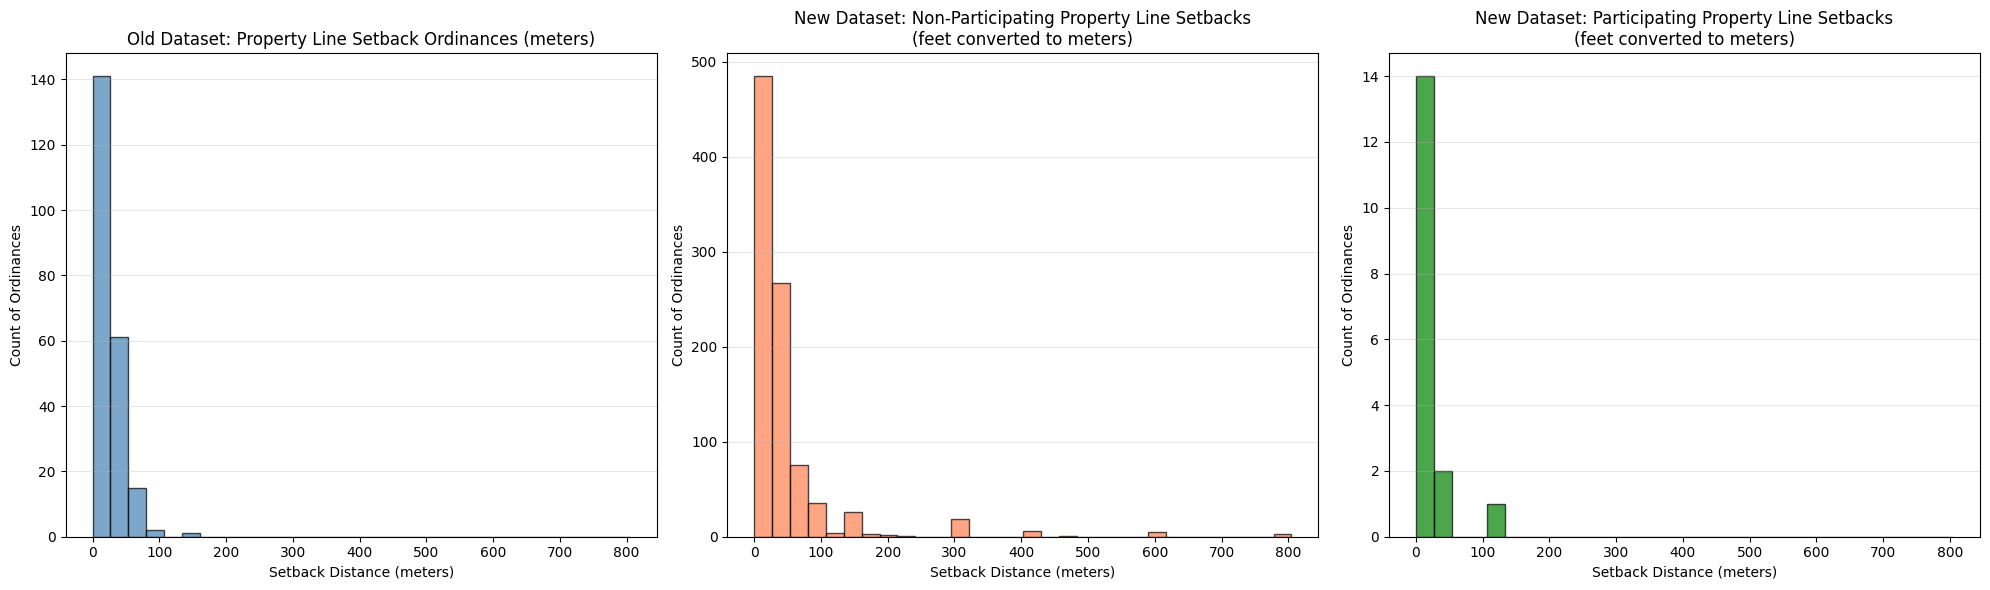

Old Dataset (Property Line, Meters only - 95.7% of all property line ordinances):
  Count: 220
  Mean: 23.57 m
  Median: 15.24 m
  Min: 1.00 m
  Max: 152.40 m

New Dataset (Non-Participating Property Line, Feet only converted to Meters - 97.9% of all non-participating 
property line ordinances):
  Count: 934
  Mean: 46.57 m
  Median: 22.86 m
  Min: 0.91 m
  Max: 804.67 m

New Dataset (Participating Property Line, Feet only converted to Meters - 100.0% of all participating property line
ordinances):
  Count: 17
  Mean: 15.55 m
  Median: 6.10 m
  Min: 0.00 m
  Max: 121.92 m

In [37]:
# Create side-by-side histograms comparing old and new property line ordinance values
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Old ordinances - Property Line with units of Meters
old_property_data = old_ord[old_ord['Feature Type'] == 'Property Line']
old_property_data = old_property_data[old_property_data['Value Type'] == 'Meters']
old_property_values = pd.to_numeric(old_property_data['Value'], errors='coerce').dropna()

# New ordinances - Property Line (Non-Participating) with units of feet (convert to meters)
new_property_nonpart_data = usable_ord[usable_ord['Feature'] == 'Property Line (Non-Participating)']
new_property_nonpart_data = new_property_nonpart_data[new_property_nonpart_data['Units'] == 'feet']
new_property_nonpart_values = pd.to_numeric(new_property_nonpart_data['Value'], errors='coerce').dropna()
new_property_nonpart_values_meters = new_property_nonpart_values * 0.3048  # Convert feet to meters

# New ordinances - Property Line (Participating) with units of feet (convert to meters)
new_property_part_data = usable_ord[usable_ord['Feature'] == 'Property Line (Participating)']
new_property_part_data = new_property_part_data[new_property_part_data['Units'] == 'feet']
new_property_part_values = pd.to_numeric(new_property_part_data['Value'], errors='coerce').dropna()
new_property_part_values_meters = new_property_part_values * 0.3048  # Convert feet to meters

# Determine common bin edges for aligned x-axes
all_property_values = pd.concat([old_property_values, new_property_nonpart_values_meters, new_property_part_values_meters])
property_bins = np.histogram_bin_edges(all_property_values, bins=30)

# Plot old ordinances
ax1.hist(old_property_values, bins=property_bins, edgecolor='black', alpha=0.7, color='steelblue')
ax1.set_xlabel('Setback Distance (meters)')
ax1.set_ylabel('Count of Ordinances')
ax1.set_title('Old Dataset: Property Line Setback Ordinances (meters)')
ax1.grid(True, alpha=0.3, axis='y')

# Plot new ordinances - Non-Participating (converted to meters)
ax2.hist(new_property_nonpart_values_meters, bins=property_bins, edgecolor='black', alpha=0.7, color='coral')
ax2.set_xlabel('Setback Distance (meters)')
ax2.set_ylabel('Count of Ordinances')
ax2.set_title('New Dataset: Non-Participating Property Line Setbacks\n(feet converted to meters)')
ax2.grid(True, alpha=0.3, axis='y')

# Plot new ordinances - Participating (converted to meters)
ax3.hist(new_property_part_values_meters, bins=property_bins, edgecolor='black', alpha=0.7, color='green')
ax3.set_xlabel('Setback Distance (meters)')
ax3.set_ylabel('Count of Ordinances')
ax3.set_title('New Dataset: Participating Property Line Setbacks\n(feet converted to meters)')
ax3.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Calculate percentages for old dataset
old_property_total = len(old_ord[old_ord['Feature Type'] == 'Property Line'])
old_property_meters_count = len(old_property_values)
old_property_meters_pct = (old_property_meters_count / old_property_total * 100) if old_property_total > 0 else 0

# Calculate percentages for new dataset - Non-Participating
new_property_nonpart_total = len(usable_ord[usable_ord['Feature'] == 'Property Line (Non-Participating)'])
new_property_nonpart_feet_count = len(new_property_nonpart_values_meters)
new_property_nonpart_feet_pct = (new_property_nonpart_feet_count / new_property_nonpart_total * 100) if new_property_nonpart_total > 0 else 0

# Calculate percentages for new dataset - Participating
new_property_part_total = len(usable_ord[usable_ord['Feature'] == 'Property Line (Participating)'])
new_property_part_feet_count = len(new_property_part_values_meters)
new_property_part_feet_pct = (new_property_part_feet_count / new_property_part_total * 100) if new_property_part_total > 0 else 0

# Print summary statistics
property_stats_output = []
property_stats_output.append(f"Old Dataset (Property Line, Meters only - {old_property_meters_pct:.1f}% of all property line ordinances):")
property_stats_output.append(f"  Count: {len(old_property_values)}")
if len(old_property_values) > 0:
    property_stats_output.append(f"  Mean: {old_property_values.mean():.2f} m")
    property_stats_output.append(f"  Median: {old_property_values.median():.2f} m")
    property_stats_output.append(f"  Min: {old_property_values.min():.2f} m")
    property_stats_output.append(f"  Max: {old_property_values.max():.2f} m")

property_stats_output.append(f"\nNew Dataset (Non-Participating Property Line, Feet only converted to Meters - {new_property_nonpart_feet_pct:.1f}% of all non-participating property line ordinances):")
property_stats_output.append(f"  Count: {len(new_property_nonpart_values_meters)}")
if len(new_property_nonpart_values_meters) > 0:
    property_stats_output.append(f"  Mean: {new_property_nonpart_values_meters.mean():.2f} m")
    property_stats_output.append(f"  Median: {new_property_nonpart_values_meters.median():.2f} m")
    property_stats_output.append(f"  Min: {new_property_nonpart_values_meters.min():.2f} m")
    property_stats_output.append(f"  Max: {new_property_nonpart_values_meters.max():.2f} m")

property_stats_output.append(f"\nNew Dataset (Participating Property Line, Feet only converted to Meters - {new_property_part_feet_pct:.1f}% of all participating property line ordinances):")
property_stats_output.append(f"  Count: {len(new_property_part_values_meters)}")
if len(new_property_part_values_meters) > 0:
    property_stats_output.append(f"  Mean: {new_property_part_values_meters.mean():.2f} m")
    property_stats_output.append(f"  Median: {new_property_part_values_meters.median():.2f} m")
    property_stats_output.append(f"  Min: {new_property_part_values_meters.min():.2f} m")
    property_stats_output.append(f"  Max: {new_property_part_values_meters.max():.2f} m")

print("\n".join(property_stats_output))

### Medium-hanging fruit

**Lot and Project Size**

Minimum and Maximum Lot size as well as Maximum Project Size hinge on our interpretation of whether the supply curve grid cell represents a single farm. This is listed as medium-hanging because it would be feasible to implement density and/or min/max lot size capacity into bespoke.

Maximum lot size is all in acres.

For reference, our supply curve grid cell is 32,792.69 acres.

***Project Size***

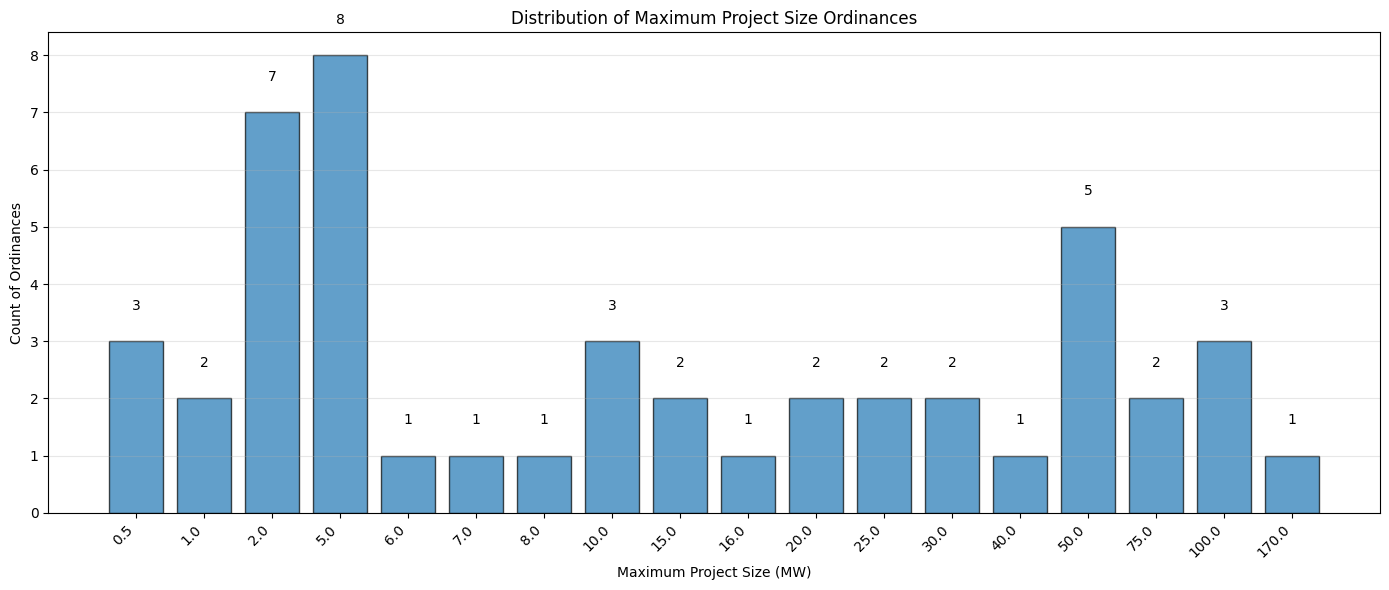

Maximum Project Size ordinances: 47
Mean: 25.8 MW
Median: 10.0 MW
Min: 0.5 MW
Max: 170.0 MW
Standard deviation: 35.5 MW
10th percentile: 1.6 MW
25th percentile: 3.5 MW
50th percentile: 10.0 MW
75th percentile: 35.0 MW
90th percentile: 75.0 MW

In [20]:
# Plot histogram of Maximum Project Size
max_project_data = usable_ord[usable_ord['Feature'] == 'Maximum Project Size']

# Collect statistics for printing later
project_stats = []

if len(max_project_data) > 0:
    # Get the values and convert to numeric
    project_values = pd.to_numeric(max_project_data['Value'], errors='coerce')
    
    # Create bar plot with value counts
    value_counts = project_values.value_counts().sort_index()
    
    plt.figure(figsize=(14, 6))
    # Use range for equal spacing, then set custom labels
    x_positions = range(len(value_counts))
    bars = plt.bar(x_positions, value_counts.values, edgecolor='black', alpha=0.7)
    plt.xlabel('Maximum Project Size (MW)')
    plt.ylabel('Count of Ordinances')
    plt.title('Distribution of Maximum Project Size Ordinances')
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on top of bars
    for i, count in enumerate(value_counts.values):
        plt.text(i, count + 0.5, str(count), ha='center', va='bottom')
    
    # Set x-axis labels to show the actual MW values
    plt.xticks(x_positions, value_counts.index, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Collect summary statistics
    project_stats.append(f"Maximum Project Size ordinances: {len(max_project_data)}")
    project_stats.append(f"Mean: {project_values.mean():.1f} MW")
    project_stats.append(f"Median: {project_values.median():.1f} MW")
    project_stats.append(f"Min: {project_values.min():.1f} MW")
    project_stats.append(f"Max: {project_values.max():.1f} MW")
    project_stats.append(f"Standard deviation: {project_values.std():.1f} MW")
    project_stats.append(f"10th percentile: {project_values.quantile(0.10):.1f} MW")
    project_stats.append(f"25th percentile: {project_values.quantile(0.25):.1f} MW")
    project_stats.append(f"50th percentile: {project_values.quantile(0.50):.1f} MW")
    project_stats.append(f"75th percentile: {project_values.quantile(0.75):.1f} MW")
    project_stats.append(f"90th percentile: {project_values.quantile(0.90):.1f} MW")
else:
    project_stats.append("No Maximum Project Size ordinances found in the data.")

# Print all statistics together
if project_stats:
    print("\n".join(project_stats))

***Lot Size***

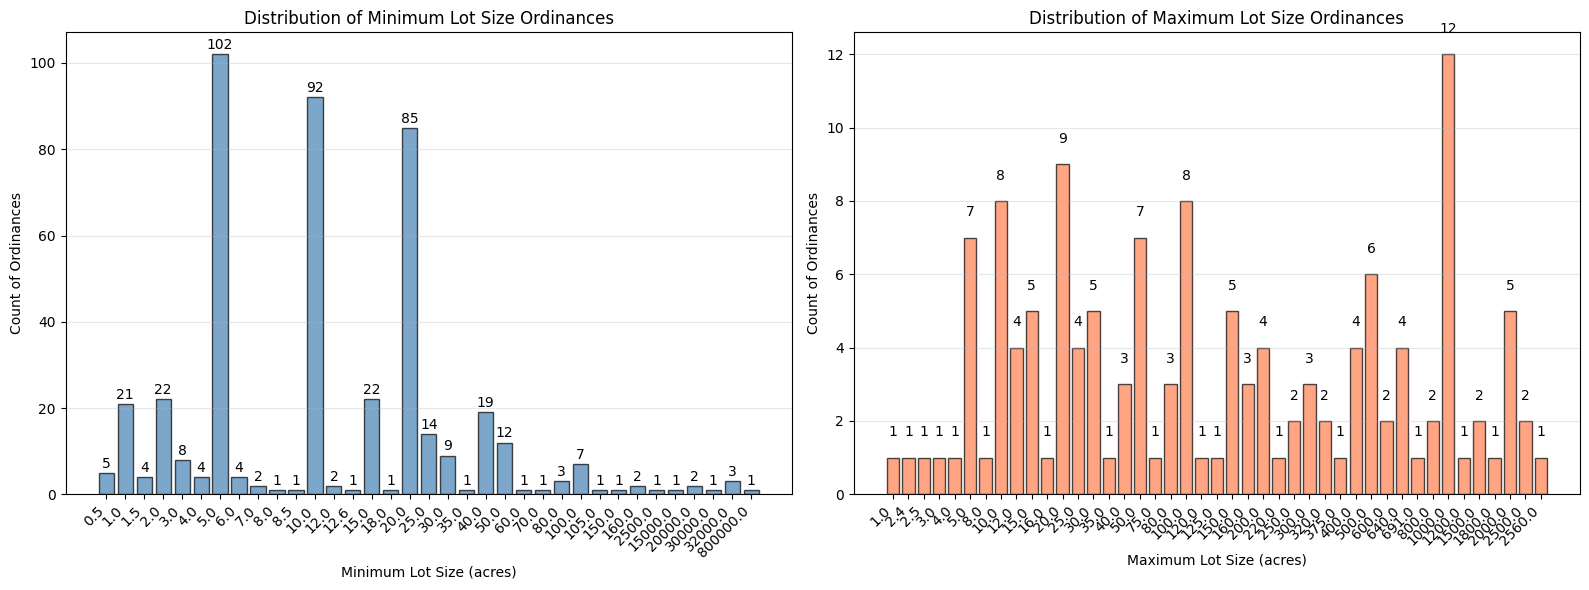

Minimum Lot Size ordinances: 457
Mean: 2168.1 acres
Median: 10.0 acres
Min: 0.5 acres
Max: 800000.0 acres
Standard deviation: 37546.9 acres

Maximum Lot Size ordinances: 138
Mean: 387.3 acres
Median: 100.0 acres
Min: 1.0 acres
Max: 2560.0 acres
Standard deviation: 586.3 acres

In [19]:
# Plot side-by-side histograms of Minimum and Maximum Lot Size ordinances
min_lot_data = usable_ord[usable_ord['Feature'] == 'Minimum Lot Size']
max_lot_data = usable_ord[usable_ord['Feature'] == 'Maximum Lot Size']

# Collect statistics for printing later
min_stats = []
max_stats = []

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Minimum Lot Size plot
if len(min_lot_data) > 0:
    min_lot_values = pd.to_numeric(min_lot_data['Value'], errors='coerce')
    min_value_counts = min_lot_values.value_counts().sort_index()
    
    x_positions = range(len(min_value_counts))
    ax1.bar(x_positions, min_value_counts.values, edgecolor='black', alpha=0.7, color='steelblue')
    ax1.set_xlabel('Minimum Lot Size (acres)')
    ax1.set_ylabel('Count of Ordinances')
    ax1.set_title('Distribution of Minimum Lot Size Ordinances')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on top of bars
    for i, count in enumerate(min_value_counts.values):
        ax1.text(i, count + 0.5, str(count), ha='center', va='bottom')
    
    # Set x-axis labels
    ax1.set_xticks(x_positions)
    ax1.set_xticklabels(min_value_counts.index, rotation=45, ha='right')
    
    # Collect summary statistics
    min_stats.append(f"Minimum Lot Size ordinances: {len(min_lot_data)}")
    min_stats.append(f"Mean: {min_lot_values.mean():.1f} acres")
    min_stats.append(f"Median: {min_lot_values.median():.1f} acres")
    min_stats.append(f"Min: {min_lot_values.min():.1f} acres")
    min_stats.append(f"Max: {min_lot_values.max():.1f} acres")
    min_stats.append(f"Standard deviation: {min_lot_values.std():.1f} acres")
else:
    ax1.text(0.5, 0.5, 'No Minimum Lot Size\nordinances found', 
             ha='center', va='center', transform=ax1.transAxes, fontsize=12)
    ax1.set_title('Distribution of Minimum Lot Size Ordinances')

# Maximum Lot Size plot
if len(max_lot_data) > 0:
    max_lot_values = pd.to_numeric(max_lot_data['Value'], errors='coerce')
    max_value_counts = max_lot_values.value_counts().sort_index()
    
    x_positions = range(len(max_value_counts))
    ax2.bar(x_positions, max_value_counts.values, edgecolor='black', alpha=0.7, color='coral')
    ax2.set_xlabel('Maximum Lot Size (acres)')
    ax2.set_ylabel('Count of Ordinances')
    ax2.set_title('Distribution of Maximum Lot Size Ordinances')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on top of bars
    for i, count in enumerate(max_value_counts.values):
        ax2.text(i, count + 0.5, str(count), ha='center', va='bottom')
    
    # Set x-axis labels
    ax2.set_xticks(x_positions)
    ax2.set_xticklabels(max_value_counts.index, rotation=45, ha='right')
    
    # Collect summary statistics
    max_stats.append(f"Maximum Lot Size ordinances: {len(max_lot_data)}")
    max_stats.append(f"Mean: {max_lot_values.mean():.1f} acres")
    max_stats.append(f"Median: {max_lot_values.median():.1f} acres")
    max_stats.append(f"Min: {max_lot_values.min():.1f} acres")
    max_stats.append(f"Max: {max_lot_values.max():.1f} acres")
    max_stats.append(f"Standard deviation: {max_lot_values.std():.1f} acres")
else:
    ax2.text(0.5, 0.5, 'No Maximum Lot Size\nordinances found', 
             ha='center', va='center', transform=ax2.transAxes, fontsize=12)
    ax2.set_title('Distribution of Maximum Lot Size Ordinances')

plt.tight_layout()
plt.show()

# Print all statistics together
if min_stats:
    print("\n".join(min_stats))
if max_stats:
    if min_stats:
        print()  # Add blank line between min and max stats
    print("\n".join(max_stats))

**Noise**

94% of the 330 are max dBA ordinances. We currently have the capability to apply noise thresholds for wind, but could likely be adapted to pv if required.

In [ ]:
noise = usable_ord[usable_ord['Feature']=='Noise']
noise = noise[noise['Units'] != 'dB above background'] 



In [32]:
# Plot histogram of noise ordinance levels
# Collect statistics for printing later
noise_stats = []

if len(noise) > 0:
    # Get the values and convert to numeric
    noise_values = pd.to_numeric(noise['Value'], errors='coerce')
    
    # # Create bar plot with value counts
    # value_counts = noise_values.value_counts().sort_index()
    
    # plt.figure(figsize=(14, 6))
    # # Use range for equal spacing, then set custom labels
    # x_positions = range(len(value_counts))
    # bars = plt.bar(x_positions, value_counts.values, edgecolor='black', alpha=0.7, color='green')
    # plt.xlabel('Noise Level (dBA)')
    # plt.ylabel('Count of Ordinances')
    # plt.title('Distribution of Noise Ordinance Levels (dBA)')
    # plt.grid(True, alpha=0.3, axis='y')
    
    # # Add value labels on top of bars
    # for i, count in enumerate(value_counts.values):
    #     plt.text(i, count + 0.5, str(count), ha='center', va='bottom')
    
    # # Set x-axis labels to show the actual dBA values
    # plt.xticks(x_positions, value_counts.index, rotation=45, ha='right')
    
    # plt.tight_layout()
    # plt.show()
    
    # Collect summary statistics (reversed percentiles since lower is more restrictive)
    noise_stats.append(f"Noise ordinances: {len(noise)}")
    noise_stats.append(f"Mean: {noise_values.mean():.1f} dBA")
    noise_stats.append(f"Median: {noise_values.median():.1f} dBA")
    noise_stats.append(f"Min (most restrictive): {noise_values.min():.1f} dBA")
    noise_stats.append(f"Max (least restrictive): {noise_values.max():.1f} dBA")
    noise_stats.append(f"Standard deviation: {noise_values.std():.1f} dBA")
    noise_stats.append(f"10th percentile (most restrictive): {noise_values.quantile(0.10):.1f} dBA")
    noise_stats.append(f"25th percentile: {noise_values.quantile(0.25):.1f} dBA")
    noise_stats.append(f"50th percentile: {noise_values.quantile(0.50):.1f} dBA")
    noise_stats.append(f"75th percentile: {noise_values.quantile(0.75):.1f} dBA")
    noise_stats.append(f"90th percentile (least restrictive): {noise_values.quantile(0.90):.1f} dBA")
else:
    noise_stats.append("No noise ordinances found in the data.")

# Print all statistics together
if noise_stats:
    print("\n".join(noise_stats))

Noise ordinances: 311
Mean: 49.6 dBA
Median: 50.0 dBA
Min (most restrictive): 8.0 dBA
Max (least restrictive): 85.0 dBA
Standard deviation: 9.4 dBA
10th percentile (most restrictive): 40.0 dBA
25th percentile: 45.0 dBA
50th percentile: 50.0 dBA
75th percentile: 55.0 dBA
90th percentile (least restrictive): 60.0 dBA

**Coverage**

95% are percent of lot area. We will need to determine what constitues a lot.

In [29]:
# Unit breakdown for Coverage ordinances
coverage_ordinances = usable_ord[usable_ord['Feature']=='Coverage']
unit_counts = coverage_ordinances['Units'].value_counts()

output_lines = [f"Total Coverage ordinances: {len(coverage_ordinances)}\n"]
output_lines.append("Units breakdown:")
for unit, count in unit_counts.items():
    percentage = (count / len(coverage_ordinances)) * 100
    output_lines.append(f"  {unit}: {count} ({percentage:.1f}%)")

print("\n".join(output_lines))

Total Coverage ordinances: 200

Units breakdown:
  percent of lot area: 189 (94.5%)
  acres: 5 (2.5%)
  percent of total jurisdiction land: 5 (2.5%)
  square feet per acre: 1 (0.5%)

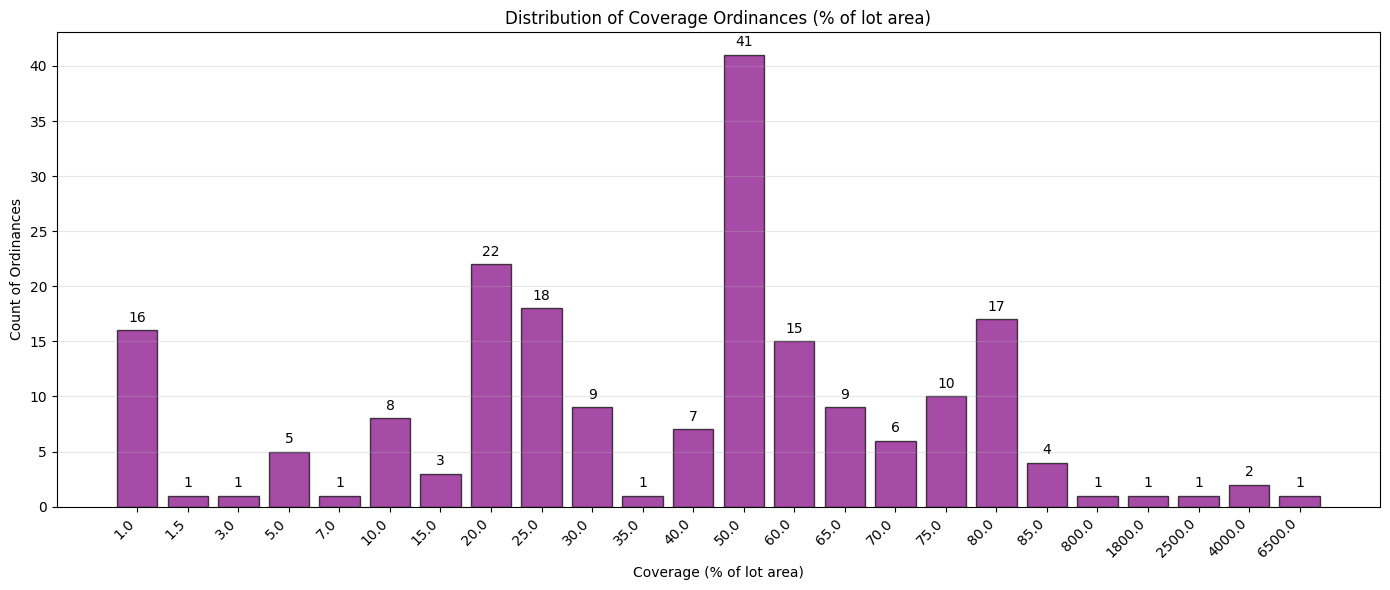

Coverage ordinances: 200
Mean: 138.3%
Median: 50.0%
Min (most restrictive): 1.0%
Max (least restrictive): 6500.0%
Standard deviation: 638.1%
10th percentile (most restrictive): 5.0%
25th percentile: 20.0%
50th percentile: 50.0%
75th percentile: 65.0%
90th percentile (least restrictive): 80.0%

In [30]:
# Plot histogram of Coverage (percent of lot area) ordinances
coverage_data = usable_ord[usable_ord['Feature'] == 'Coverage']

# Collect statistics for printing later
coverage_stats = []

if len(coverage_data) > 0:
    # Get the values and convert to numeric
    coverage_values = pd.to_numeric(coverage_data['Value'], errors='coerce')
    
    # Create bar plot with value counts
    value_counts = coverage_values.value_counts().sort_index()
    
    plt.figure(figsize=(14, 6))
    # Use range for equal spacing, then set custom labels
    x_positions = range(len(value_counts))
    bars = plt.bar(x_positions, value_counts.values, edgecolor='black', alpha=0.7, color='purple')
    plt.xlabel('Coverage (% of lot area)')
    plt.ylabel('Count of Ordinances')
    plt.title('Distribution of Coverage Ordinances (% of lot area)')
    plt.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on top of bars
    for i, count in enumerate(value_counts.values):
        plt.text(i, count + 0.5, str(count), ha='center', va='bottom')
    
    # Set x-axis labels to show the actual percentage values
    plt.xticks(x_positions, value_counts.index, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    # Collect summary statistics (lower values are more restrictive)
    coverage_stats.append(f"Coverage ordinances: {len(coverage_data)}")
    coverage_stats.append(f"Mean: {coverage_values.mean():.1f}%")
    coverage_stats.append(f"Median: {coverage_values.median():.1f}%")
    coverage_stats.append(f"Min (most restrictive): {coverage_values.min():.1f}%")
    coverage_stats.append(f"Max (least restrictive): {coverage_values.max():.1f}%")
    coverage_stats.append(f"Standard deviation: {coverage_values.std():.1f}%")
    coverage_stats.append(f"10th percentile (most restrictive): {coverage_values.quantile(0.10):.1f}%")
    coverage_stats.append(f"25th percentile: {coverage_values.quantile(0.25):.1f}%")
    coverage_stats.append(f"50th percentile: {coverage_values.quantile(0.50):.1f}%")
    coverage_stats.append(f"75th percentile: {coverage_values.quantile(0.75):.1f}%")
    coverage_stats.append(f"90th percentile (least restrictive): {coverage_values.quantile(0.90):.1f}%")
else:
    coverage_stats.append("No Coverage ordinances found in the data.")

# Print all statistics together
if coverage_stats:
    print("\n".join(coverage_stats))

#### Misc. Analysis

**Unit Analysis**

This is the original data set units, and is meant to inform above analyses.

In [27]:
# For each ordinance type (Feature), display unique units and their counts within usable ordinances
output_lines = ["Units and counts for each ordinance feature type (usable ordinances only):\n"]

for feature in sorted(usable_ord.Feature.unique()):
    feature_data = usable_ord[usable_ord.Feature == feature]
    unit_counts = feature_data.Units.value_counts()
    
    output_lines.append(f"Feature: {feature}")
    output_lines.append(f"Total ordinances: {len(feature_data)}")
    output_lines.append("Units breakdown:")
    for unit, count in unit_counts.items():
        percentage = (count / len(feature_data)) * 100
        output_lines.append(f"  {unit}: {count} ({percentage:.1f}%)")
    output_lines.append("-" * 60)

# Print all output at once
print("\n".join(output_lines))

Units and counts for each ordinance feature type (usable ordinances only):

Feature: Coverage
Total ordinances: 200
Units breakdown:
  percent of lot area: 189 (94.5%)
  acres: 5 (2.5%)
  percent of total jurisdiction land: 5 (2.5%)
  square feet per acre: 1 (0.5%)
------------------------------------------------------------
Feature: Maximum Height
Total ordinances: 808
Units breakdown:
  feet: 808 (100.0%)
------------------------------------------------------------
Feature: Maximum Lot Size
Total ordinances: 138
Units breakdown:
  acres: 138 (100.0%)
------------------------------------------------------------
Feature: Maximum Project Size
Total ordinances: 47
Units breakdown:
  MW: 40 (85.1%)
  MW (AC): 5 (10.6%)
  MW (DC): 2 (4.3%)
------------------------------------------------------------
Feature: Minimum Lot Size
Total ordinances: 457
Units breakdown:
  acres: 449 (98.2%)
  square feet: 8 (1.8%)
------------------------------------------------------------
Feature: Noise
Total ordinances: 330
Units breakdown:
  dBA: 306 (92.7%)
  dB above background: 19 (5.8%)
  dB: 4 (1.2%)
  dBC: 1 (0.3%)
------------------------------------------------------------
Feature: Other Secs
Total ordinances: 36
Units breakdown:
  miles: 26 (72.2%)
  feet: 10 (27.8%)
------------------------------------------------------------
Feature: Panel Spacing
Total ordinances: 2
Units breakdown:
  feet: 2 (100.0%)
------------------------------------------------------------
Feature: Property Line (Non-Participating)
Total ordinances: 954
Units breakdown:
  feet: 934 (97.9%)
  structure-height-multiplier: 19 (2.0%)
  miles: 1 (0.1%)
------------------------------------------------------------
Feature: Property Line (Participating)
Total ordinances: 17
Units breakdown:
  feet: 17 (100.0%)
------------------------------------------------------------
Feature: Public Conservation Lands
Total ordinances: 61
Units breakdown:
  feet: 57 (93.4%)
  miles: 4 (6.6%)
------------------------------------------------------------
Feature: Railroads
Total ordinances: 21
Units breakdown:
  feet: 21 (100.0%)
------------------------------------------------------------
Feature: Roads
Total ordinances: 527
Units breakdown:
  feet: 509 (96.6%)
  structure-height-multiplier: 16 (3.0%)
  miles: 2 (0.4%)
------------------------------------------------------------
Feature: Structures (Non-Participating)
Total ordinances: 608
Units breakdown:
  feet: 595 (97.9%)
  miles: 7 (1.2%)
  structure-height-multiplier: 6 (1.0%)
------------------------------------------------------------
Feature: Structures (Participating)
Total ordinances: 18
Units breakdown:
  feet: 17 (94.4%)
  structure-height-multiplier: 1 (5.6%)
------------------------------------------------------------
Feature: Transmission
Total ordinances: 27
Units breakdown:
  feet: 25 (92.6%)
  structure-height-multiplier: 2 (7.4%)
------------------------------------------------------------
Feature: Water
Total ordinances: 124
Units breakdown:
  feet: 118 (95.2%)
  miles: 5 (4.0%)
  dBA: 1 (0.8%)
------------------------------------------------------------